## Exploratory Data Analysis
In this first level of data exploration, I will analyze and describe key aspects of the dataset, focusing on uncovering insights from my perspective. This level is designed for beginners, but I aim to provide a structured and thoughtful approach to answering the given questions. Specifically, I will explore the following:

+ What is the first and last date readings were taken on?
+ What is the average torque?
+ Which assembly line has the highest readings of machine downtime?

Through this process, I will apply fundamental data analysis techniques to extract meaningful insights and set the foundation for deeper exploration in subsequent levels.

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from scipy.stats import sem
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.seasonal import STL

from typing import Tuple, Union
from itertools import product
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-colorblind')
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


In [3]:
# read the cleaned data as a dataframe
machine_ori = pd.read_csv('../data/machine_downtime_cleaned.csv', parse_dates=['Date'])
machine_ori.columns

Index(['Date', 'Machine_ID', 'Assembly_Line_No', 'Coolant_Temperature',
       'Hydraulic_Oil_Temperature', 'Spindle_Bearing_Temperature',
       'Spindle_Vibration', 'Tool_Vibration', 'Voltage(volts)', 'Torque(Nm)',
       'Downtime', 'Hydraulic_Pressure(Pa)', 'Coolant_Pressure(Pa)',
       'Air_System_Pressure(Pa)', 'Cutting(N)', 'Spindle_Speed(RPS)'],
      dtype='object')

## Feature Engineering
+ Extract month, day and year from the date column
+ set date column as index


In [4]:
# extract year, month, day of the week and week
# from date column
machine_ori['Day'] = machine_ori.Date.dt.day_name()
machine_ori['Month'] = machine_ori.Date.dt.month
machine_ori['Year'] = machine_ori.Date.dt.year
#machine_ori['Week'] = machine_ori.Date.dt.isocalendar().week.astype('int')


# verify 
machine_ori.head(3)

,Date,Machine_ID,Assembly_Line_No,Coolant_Temperature,Hydraulic_Oil_Temperature,Spindle_Bearing_Temperature,Spindle_Vibration,Tool_Vibration,Voltage(volts),Torque(Nm),Downtime,Hydraulic_Pressure(Pa),Coolant_Pressure(Pa),Air_System_Pressure(Pa),Cutting(N),Spindle_Speed(RPS),Day,Month,Year
0,2021-12-08,Makino-L2-Unit1-2015,Shopfloor-L2,4.5,47.9,31.2,1.225,35.214,381.0,23.091903,No_Machine_Failure,14115919.3,513860.1,612765.0,2870.0,253.6,Wednesday,12,2021
1,2021-12-17,Makino-L2-Unit1-2015,Shopfloor-L2,21.7,47.5,35.8,1.078,29.198,367.0,31.620335,No_Machine_Failure,7246602.0,514111.3,662932.2,2970.0,295.4,Friday,12,2021
2,2021-12-17,Makino-L1-Unit1-2013,Shopfloor-L1,5.2,49.4,34.2,1.266,30.206,340.0,15.900716,Machine_Failure,8828000.0,683941.3,656038.1,2700.0,466.0,Friday,12,2021


### 1.1 What is the first and last date readings were taken on?

The data from the machine downtime for the company was taken between 11th of November 2021 to 3rd of July 2024. So roughly, we can say that we have about 9 months of machine downtime data


In [5]:
#get the first and last date reading
machine_ori['Date'].agg(['min', 'max'])

min   2021-12-08
max   2022-07-03
Name: Date, dtype: datetime64[ns]

### 1.2 What is the average torque?
In this level of data exploration, one of the key tasks is to determine the average torque. However, instead of computing a single overall average, which could introduce bias due to the presence of three different machines on each floor, a more accurate approach is to calculate the average torque for each machine separately. This ensures that we account for variations between different machines and provide a more precise representation of the data.

Torque is a crucial measurement in industrial settings, representing the rotational force applied to a machine. It directly impacts the efficiency, performance, and maintenance needs of machinery. Understanding the average torque for each machine allows us to identify potential operational inconsistencies and optimize machine performance.

To enhance interpretability, we will visualize the average torque per machine using a well-structured bar chart. This visualization will include appropriate color schemes, annotations, and a clear layout to make the insights more accessible and actionable.

### 1.2.1 How close are the troque values to the average? 

While the average torque gives us an overall idea of the force exerted by each machine, it doesn't tell us how consistent the readings are over time. This is where standard deviation comes in.

+ A low standard deviation means the torque values are closely packed around the mean, indicating consistent machine performance.
+ A high standard deviation means the torque values fluctuate more, suggesting variability in machine operation, which could be due to load changes, tool wear, or operational inconsistencies.

By analyzing standard deviation, we can determine whether a machine maintains stable performance or if there are significant variations that might require further investigation.

Torque is a measure of the rotational force applied to a machine, expressed in Newton-meters (Nm). It plays a crucial role in determining machine efficiency, stability, and overall performance. In our analysis, we computed the average torque along with the standard deviation for each machine unit:

+ Makino-L1-Unit1-2013: 24.98 Nm ± 6.07 Nm
+ Makino-L2-Unit1-2015: 25.21 Nm ± 6.22 Nm
+ Makino-L3-Unit1-2015: 25.56 Nm ± 6.07 Nm

The average torque tells us the typical force exerted by each machine, while the standard deviation (SD) provides insight into how much the torque values fluctuate over time.

+ A higher standard deviation (like 6.22 Nm for Makino-L2) indicates greater variation in torque readings, which could be due to changing loads, machine wear, or inconsistent operation.
+ A lower standard deviation suggests more stable and predictable performance.

By analyzing both metrics together, we can assess machine consistency, detect potential inefficiencies, and ensure optimal operation.

**Makino-L2-Unit1-2015** has the highest standard deviation (6.22 Nm), meaning its torque values fluctuate the most. **Makino-L1 and Makino-L3** have a standard deviation of around 6.07 Nm, slightly lower than Makino-L2.

Possible Causes:
+ Inconsistent workload distribution
+ Tool wear or improper calibration
+ Irregular material properties affecting 



In [6]:
# get the average torque
# Grouping by machine and calculating average torque
avg_torque_per_machine = machine_ori.groupby('Machine_ID')['Torque(Nm)'].agg(['mean', 'std']).reset_index()
avg_torque_per_machine

,Machine_ID,mean,std
0,Makino-L1-Unit1-2013,24.989764,6.075603
1,Makino-L2-Unit1-2015,25.210580,6.219515
2,Makino-L3-Unit1-2015,25.567039,6.078901


### 1.3 Assembly Line No with highest reading of machine failures

In addition to analyzing torque, we also examined the number of machine failures across different assembly lines. Machine failures can be caused by various factors, such as mechanical wear, excessive loads, improper calibration, or environmental conditions. Below are the recorded failures for each assembly line:

+ Shopfloor-L1: 454 failures (Highest)
+ Shopfloor-L3: 415 failures
+ Shopfloor-L2: 396 failures (Lowest)

Key Observations:
+ Shopfloor-L1 has the highest number of failures (454), indicating that machines in this section may be experiencing higher stress, improper maintenance, or operational inefficiencies.
+ Shopfloor-L3 is slightly better but still has a significant failure count (415).
+ Shopfloor-L2 has the lowest failure count (396), suggesting it may have better maintenance or less intensive workloads.

In [7]:
# get Number of machine failure that occur on each assembly line
machine_failure_reading = machine_ori[machine_ori['Downtime'] =='Machine_Failure'].\
                          groupby('Assembly_Line_No')['Downtime'].value_counts().reset_index()
                          
# sort the number of machine failure for each assembly line in decending order
machine_failure_reading.sort_values(by = 'count', ascending=False)

,Assembly_Line_No,Downtime,count
0,Shopfloor-L1,Machine_Failure,450
2,Shopfloor-L3,Machine_Failure,411
1,Shopfloor-L2,Machine_Failure,396


### Correlation Analysis

Key Observations

1️⃣ Strongest Positive Correlations
+ Torque (Nm) & Hydraulic Pressure (Pa) → (0.17)
+ This suggests that as hydraulic pressure increases, torque also tends to increase.
+ Cutting Force (N) & Spindle Speed (Rps) → (0.24)
+ Higher spindle speeds are associated with an increase in cutting force.
+ Coolant Pressure (Pa) & Cutting Force (N) → (0.18)

A slight positive correlation suggests that higher coolant pressure may correspond with increased cutting force.

2️⃣ Notable Negative Correlations
+ Torque (Nm) & Cutting Force (N) → (-0.18)
+ This could indicate that when torque increases, cutting force tends to reduce slightly, possibly due to tool efficiency or load balancing mechanisms.
+ Spindle Speed (Rps) & Torque (Nm) → (-0.21)

This suggests that as spindle speed increases, the torque applied to the machine decreases, which is expected in high-speed machining operations.
Cutting Force (N) & Hydraulic Pressure (Pa) → (-0.22)
This might indicate that when hydraulic pressure is higher, the cutting force needed is lower, possibly due to improved lubrication or stabilization effects.

3️⃣ Weak/No Correlation
Most other variables have very weak correlation values (close to 0), indicating little to no linear relationship. For instance:
+ Coolant Temperature vs. Spindle Bearing Temperature (-0.013) suggests minimal dependency.
+ Voltage vs. Spindle Vibration (0.0063) shows no meaningful relationship.


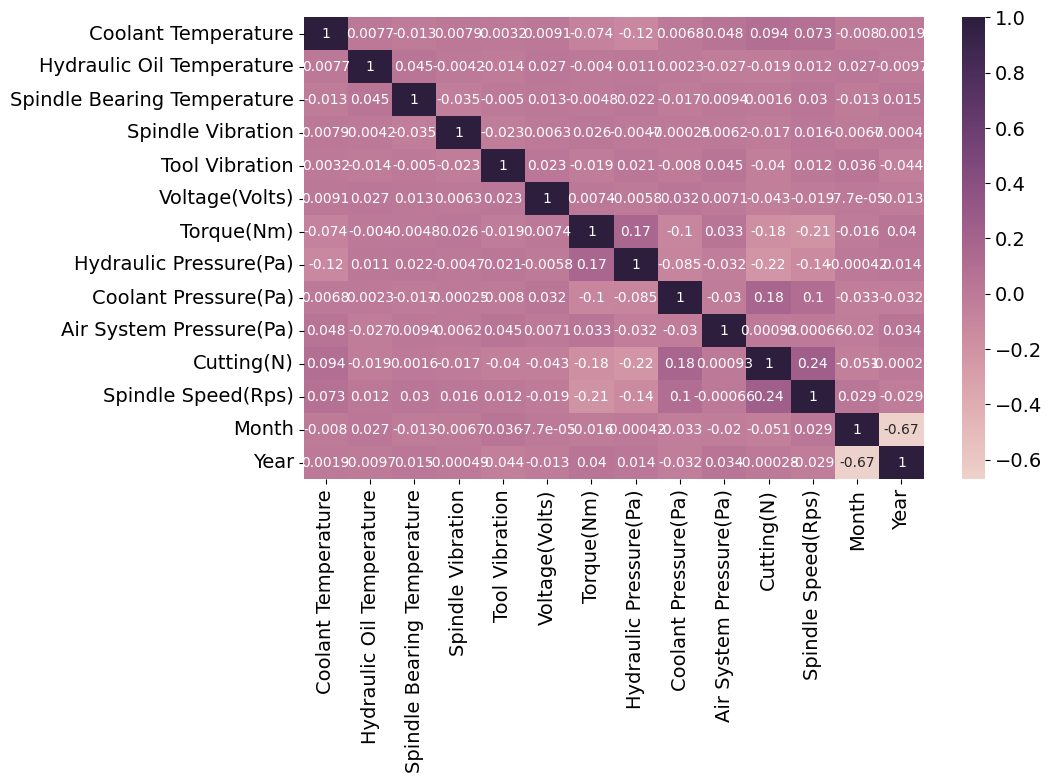

In [8]:
# copy the data 
machine_ori_encoded = machine_ori.copy()

# create a custom 
h_labels = [x.replace('_', ' ').title() for x in 
            list(machine_ori_encoded.select_dtypes(include=['number']).columns.values)]

# Select only numeric columns
numeric_df = machine_ori_encoded.select_dtypes(include=['number'])

fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(numeric_df.corr(), annot=True, 
                xticklabels=h_labels, yticklabels=h_labels, 
                cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

## Reliability Analysis of Each Machine
To evaluate the reliability of each machine, you can analyze Mean Time Between Failures (MTBF) and Failure Rate.

#### 1. Calculate Time Between Failures (TBF)**
> Group data by Machine_ID.

> Find the time difference between successive failures.

**The NaN values in the Time_Diff column suggest that:**

> NaN values: These appear for the first failure entry of each machine because there’s no previous failure to calculate a time difference. Since that is the case we could replace the NaN with 0 to help our next calculation. We woul do that when calculating mean time betwen failures

In [9]:
machine_failure = machine_ori[machine_ori['Downtime'] == 'Machine_Failure'].copy()
# Drop duplicate failures on the same date for the same machine
machine_failure = machine_failure.drop_duplicates(subset=['Machine_ID', 'Date'])

# Compute Time Between Failures (TBF)
machine_failure['Time_Diff'] = machine_failure.groupby('Machine_ID')['Date'].diff().dt.days

print(machine_failure[['Machine_ID', 'Date', 'Time_Diff']].head(20))


              Machine_ID       Date  Time_Diff
2   Makino-L1-Unit1-2013 2021-12-17        NaN
4   Makino-L2-Unit1-2015 2021-12-21        NaN
10  Makino-L1-Unit1-2013 2021-12-27       10.0
11  Makino-L3-Unit1-2015 2021-12-27        NaN
14  Makino-L2-Unit1-2015 2021-12-28        7.0
16  Makino-L1-Unit1-2013 2021-12-28        1.0
19  Makino-L1-Unit1-2013 2021-12-30        2.0
21  Makino-L1-Unit1-2013 2021-12-31        1.0
23  Makino-L3-Unit1-2015 2021-12-31        4.0
24  Makino-L1-Unit1-2013 2022-01-03        3.0
27  Makino-L3-Unit1-2015 2022-01-06        6.0
28  Makino-L2-Unit1-2015 2022-01-06        9.0
34  Makino-L1-Unit1-2013 2022-01-07        4.0
35  Makino-L2-Unit1-2015 2022-01-08        2.0
38  Makino-L1-Unit1-2013 2022-01-08        1.0
40  Makino-L3-Unit1-2015 2022-01-09        3.0
41  Makino-L2-Unit1-2015 2022-01-09        1.0
44  Makino-L1-Unit1-2013 2022-01-10        2.0
48  Makino-L1-Unit1-2013 2022-01-11        1.0
49  Makino-L3-Unit1-2015 2022-01-11        2.0


#### 2. Compute MTBF (Mean time between Failures) for Each Machine

Mean time between failure (MTBF) is a measure of the reliability of a system or component. It’s a crucial element of maintenance management, representing the average time that a system or component will operate before it fails.

The MTBF formula is often used in the context of industrial or electronic system maintainability, where failure of a component can lead to significant downtime or even safety risks, but MTBF is used across many types of repairable systems and diverse industries.

It can help measure the overall reliability of manufacturing plants, energy grids, information networks and countless other use cases. ('https://www.ibm.com/think/topics/mtbf')['IBM']

**Key Insights & Recommendations:**

Makino-L1-Unit1-2013 has the highest MTBF (1.584 days)
+ This machine runs the longest before breaking down.
+ Recommendation: Keep maintenance schedules the same or optimize them further.

Makino-L3-Unit1-2015 has the lowest MTBF (1.366 days)
+ This machine fails the most frequently.
+ Recommendation: Investigate possible causes (wear and tear, overheating, vibration, or improper usage). Preventive maintenance should be increased.

MTBF Differences are Small (~0.2 days apart)
+ The variation in MTBF is not very large, but Makino-L3 needs attention.
+ You may analyze failure patterns further: Does it fail under specific conditions (high spindle speed, high cutting force, etc.)?

In [10]:
# replace NaN with zero
machine_failure['Time_Diff'] = machine_failure['Time_Diff'].replace('NaN', 0)
# compute MTBF
mtbf = machine_failure.groupby('Machine_ID')['Time_Diff'].mean()
print(mtbf)

Machine_ID
Makino-L1-Unit1-2013    1.584000
Makino-L2-Unit1-2015    1.539823
Makino-L3-Unit1-2015    1.366071
Name: Time_Diff, dtype: float64


In [18]:
mtbf.head()

,Time_Diff
Machine_ID,
Makino-L1-Unit1-2013,1.584000
Makino-L2-Unit1-2015,1.539823
Makino-L3-Unit1-2015,1.366071


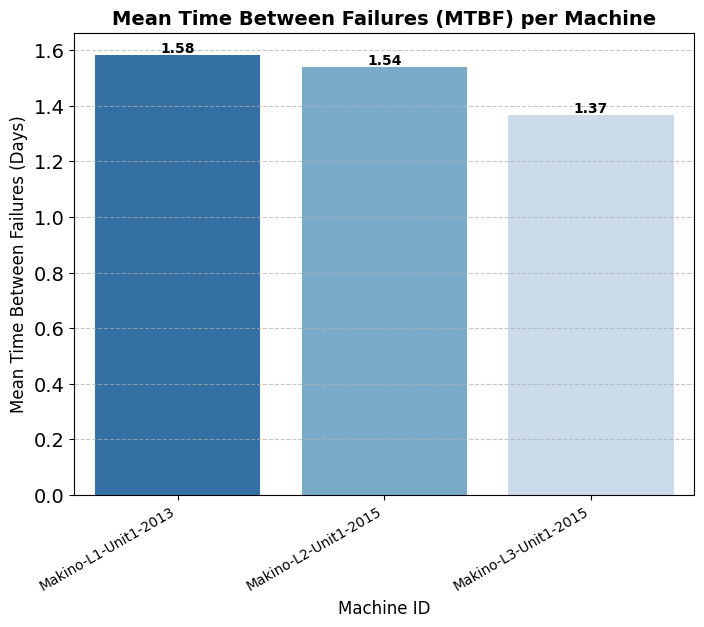

In [23]:
# sort the MTBF in descending order
mtbf = pd.DataFrame(mtbf)
mtbf = mtbf.sort_values(by = 'Time_Diff', ascending= False)

# Create a Beautiful Plot
plt.figure(figsize=(8, 6))
cmap = sns.color_palette("coolwarm", as_cmap=True)  # Gradient colors
sns.barplot(data=mtbf, x='Machine_ID', y='Time_Diff', palette="Blues_r")

# Title and labels
plt.title('Mean Time Between Failures (MTBF) per Machine', fontsize=14, fontweight='bold')
plt.xlabel('Machine ID', fontsize=12)
plt.ylabel('Mean Time Between Failures (Days)', fontsize=12)
plt.xticks(rotation=30, ha="right", fontsize=10)

# Add value labels
for index, row in enumerate(mtbf['Time_Diff']):
    plt.text(index, row + 0.01, f'{row:.2f}', ha='center', fontsize=10, fontweight='bold')

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### 3. Compute Failure Rate
What is Failure Rate?
Failure rate (𝜆) measures how frequently a machine fails per unit time (e.g., failures per day). A higher failure rate means the machine fails more often and is less reliable. It is calculated as follows

Failure Rate (𝜆) = Total Failures / Total Operating Time

**Key Insights & Recommendations:**
1. Makino-L1-Unit1-2013 has the highest failure rate (0.6087 failures per day)
+ This machine is the least reliable.
+ Recommendation: Increase preventive maintenance and inspect for common failure causes (e.g., overheating, vibration, pressure issues).

2. Makino-L3-Unit1-2015 has the lowest failure rate (0.5459 failures per day)2
+ This machine is the most reliable.
+ Recommendation: Keep maintenance strategies consistent to maintain reliability.

> Failure rates are close in value (~0.06 difference)

The variation in failure rate is small, but Makino-L1 is still the most problematic.
Investigate if failures are related to specific operational conditions (e.g., high spindle speed, torque, or pressure levels).


In [24]:
# claculate the total operating time
total_time = (machine_ori['Date'].max() - machine_ori['Date'].min()).days  # Total days observed
failure_counts = machine_failure['Machine_ID'].value_counts() # number of failures

failure_rate = failure_counts / total_time # claculat failure rate
print(failure_rate)    # print the failure rate

Machine_ID
Makino-L1-Unit1-2013    0.608696
Makino-L2-Unit1-2015    0.550725
Makino-L3-Unit1-2015    0.545894
Name: count, dtype: float64


### Time Series Decomposition

✅ The key features to focus on:

+ Torque (Nm), Hydraulic Pressure (Pa), Cutting Force (N), Spindle Speed (Rps), Coolant Pressure (Pa)
+ Machine Failure occurrences (target variable)

In [ ]:

# Set date as index so can do resampling using pandas
machine_ori.set_index('Date', inplace=True)

machine_numeric = machine_ori.select_dtypes(include=['number'])

# set the monthly avaerage 
machine_monthly = machine_numeric.resample('M').mean()